# Setup

In [ ]:
!pip install flaml[automl]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.9/313.9 kB 6.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import random
import os
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/UNIBO/MachineLearning/chip_dataset.csv'
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import random
import os
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

# Data Understanding

In [ ]:
df

,Product,Type,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (GHz),Foundry,Vendor,FP16 GFLOPS,FP32 GFLOPS,FP64 GFLOPS
0,AMD Athlon 1000,CPU,6/5/00,180,54,120,37,1000.0,NaN,AMD,NaN,NaN,NaN
1,AMD Athlon 1000,CPU,10/31/00,180,54,120,37,1000.0,NaN,AMD,NaN,NaN,NaN
2,AMD Athlon 1100,CPU,8/14/00,180,60,120,37,1100.0,NaN,AMD,NaN,NaN,NaN
3,AMD Athlon 1133,CPU,10/31/00,180,63,120,37,1133.0,NaN,AMD,NaN,NaN,NaN
4,AMD Athlon 1200,CPU,10/31/00,180,66,120,37,1200.0,NaN,AMD,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4940,NVIDIA GeForce RTX 3050 6 GB,GPU,NaN,8,80,200,8700,1042.0,Samsung,NVIDIA,6021.0,6021.0,94.08
4941,NVIDIA GeForce RTX 4070 SUPER,GPU,1/8/24,5,220,294,35800,1980.0,TSMC,NVIDIA,35480.0,35480.0,554.40
4942,NVIDIA GeForce RTX 4070 Ti SUPER,GPU,1/8/24,5,285,379,45900,2340.0,TSMC,NVIDIA,44100.0,44100.0,689.00
4943,NVIDIA GeForce RTX 4080 SUPER,GPU,1/8/24,5,320,379,45900,2295.0,TSMC,NVIDIA,52220.0,52220.0,816.00


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4945 entries, 0 to 4944
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Product                4945 non-null   object 
 1   Type                   4945 non-null   object 
 2   Release Date           4746 non-null   object 
 3   Process Size (nm)      4945 non-null   object 
 4   TDP (W)                4508 non-null   object 
 5   Die Size (mm^2)        4593 non-null   object 
 6   Transistors (million)  4390 non-null   object 
 7   Freq (GHz)             4508 non-null   float64
 8   Foundry                4330 non-null   object 
 9   Vendor                 4945 non-null   object 
 10  FP16 GFLOPS            800 non-null    float64
 11  FP32 GFLOPS            1685 non-null   float64
 12  FP64 GFLOPS            1278 non-null   float64
dtypes: float64(4), object(9)
memory usage: 502.4+ KB


In [ ]:
df.describe()

,Freq (GHz),FP16 GFLOPS,FP32 GFLOPS,FP64 GFLOPS
count,4508.000000,800.000000,1685.000000,1278.000000
mean,1615.430790,19033.061063,5403.009359,1096.608263
std,1084.641452,44865.341218,11492.095538,5232.537404
min,100.000000,10.020000,12.800000,3.600000
25%,650.000000,1299.500000,384.000000,59.247500
50%,1400.000000,6136.500000,1248.000000,136.350000
75%,2500.000000,20175.000000,5069.000000,382.450000
max,4700.000000,653700.000000,93240.000000,81720.000000


# Data cleaning
Preprocessing:
- Drop `Product`, `Foundry`, `Release Date`, `Vendor`, `Type`
- Select data of type `GPU`
- Drop rows with missing target values
- Drop rows with value `unknown`
- Convert specifications to numeric values

In [ ]:
# Step 1: Remove all rows where 'Type' column contains 'CPU'
df_GPU = df[df['Type'] != 'CPU']
# Step 2: Remove irrelevant columns
df_relevant = df_GPU.drop(columns=['Product', 'Foundry', 'Release Date', 'Vendor','Type'])
# Step 3: Drop rows with missing target values (FP16, FP32, FP64 GFLOPS)
df_drop1 = df_relevant.dropna(subset=['FP16 GFLOPS', 'FP32 GFLOPS', 'FP64 GFLOPS'])
unknown_rows = df_drop1[df_drop1.isin(['unknown']).any(axis=1)]
df_drop2 = df_drop1.drop(unknown_rows.index)
df = df_drop2

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 658 entries, 3786 to 4944
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Process Size (nm)      658 non-null    object 
 1   TDP (W)                658 non-null    object 
 2   Die Size (mm^2)        658 non-null    object 
 3   Transistors (million)  658 non-null    object 
 4   Freq (GHz)             658 non-null    float64
 5   FP16 GFLOPS            658 non-null    float64
 6   FP32 GFLOPS            658 non-null    float64
 7   FP64 GFLOPS            658 non-null    float64
dtypes: float64(4), object(4)
memory usage: 46.3+ KB


In [ ]:
df['TDP (W)'] = pd.to_numeric(df['TDP (W)'])
df['Freq (GHz)'] = pd.to_numeric(df['Freq (GHz)'])
df['Process Size (nm)'] = df['Process Size (nm)'].astype(str)
df['Process Size (nm)'] = df['Process Size (nm)'].str.extract('(\d+)')
df['Process Size (nm)'] = pd.to_numeric(df['Process Size (nm)'])
df['Die Size (mm^2)'] = df['Die Size (mm^2)'].astype(str)
df['Die Size (mm^2)'] = pd.to_numeric(df['Die Size (mm^2)'])
df['Transistors (million)'] = pd.to_numeric(df['Transistors (million)'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 658 entries, 3786 to 4944
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Process Size (nm)      658 non-null    int64  
 1   TDP (W)                658 non-null    int64  
 2   Die Size (mm^2)        658 non-null    int64  
 3   Transistors (million)  658 non-null    int64  
 4   Freq (GHz)             658 non-null    float64
 5   FP16 GFLOPS            658 non-null    float64
 6   FP32 GFLOPS            658 non-null    float64
 7   FP64 GFLOPS            658 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 46.3 KB


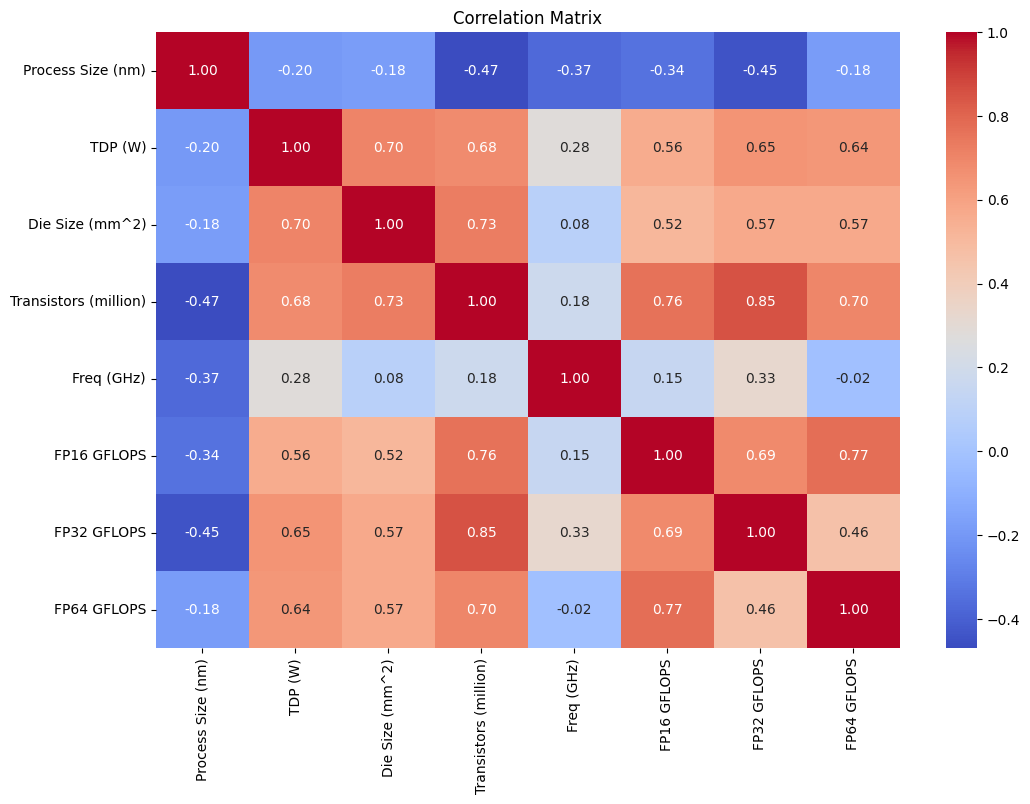

In [ ]:
import seaborn as sns
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt = ".2f", cbar=True)
plt.title('Correlation Matrix')
plt.show()

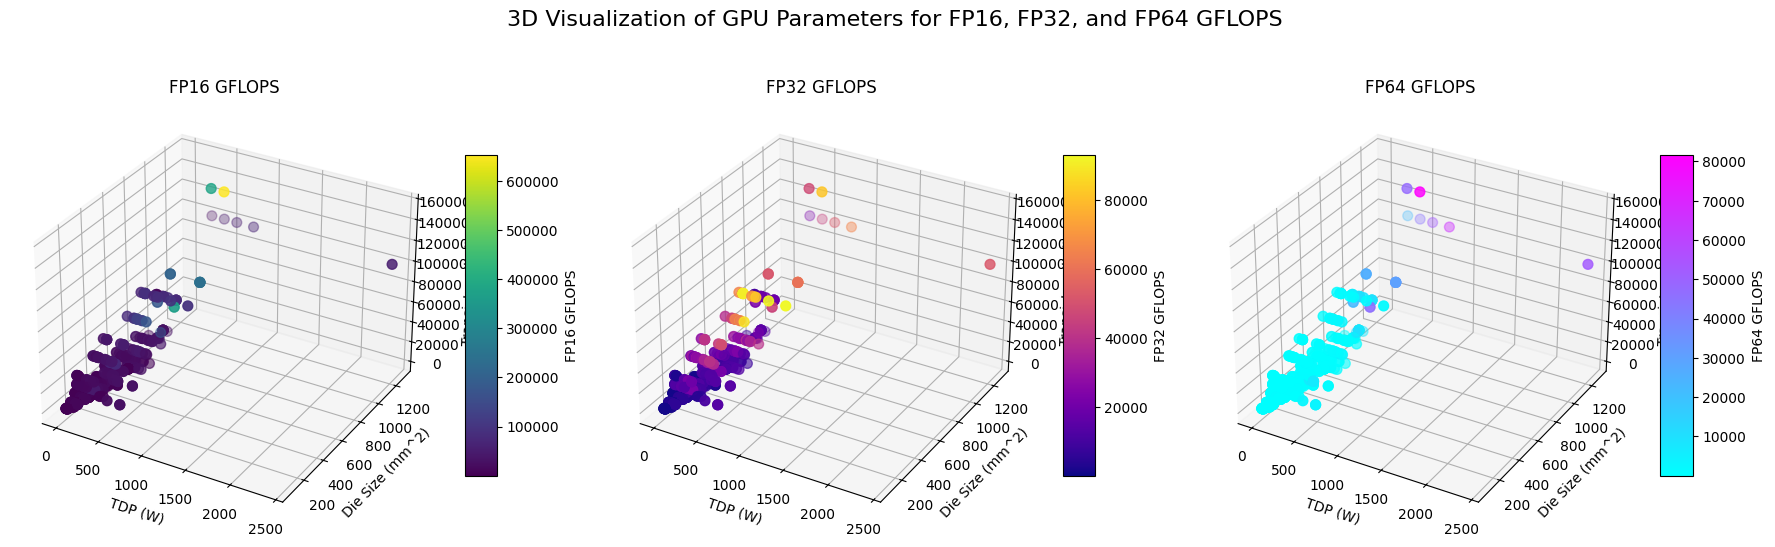

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
# Create a 3D scatter plot for FP16, FP32, and FP64 as subplots in one figure
fig = plt.figure(figsize=(18, 6))

# FP16 GFLOPS
ax1 = fig.add_subplot(131, projection='3d')
scatter1 = ax1.scatter(
    df['TDP (W)'], df['Die Size (mm^2)'], df['Transistors (million)'],
    c=df['FP16 GFLOPS'], cmap='viridis', s=50
)
cbar1 = fig.colorbar(scatter1, ax=ax1, shrink=0.6, aspect=10)
cbar1.set_label('FP16 GFLOPS', fontsize=10)
ax1.set_xlabel('TDP (W)', fontsize=10)
ax1.set_ylabel('Die Size (mm^2)', fontsize=10)
ax1.set_zlabel('Transistors (million)', fontsize=10)
ax1.set_title('FP16 GFLOPS', fontsize=12)

# FP32 GFLOPS
ax2 = fig.add_subplot(132, projection='3d')
scatter2 = ax2.scatter(
    df['TDP (W)'], df['Die Size (mm^2)'], df['Transistors (million)'],
    c=df['FP32 GFLOPS'], cmap='plasma', s=50
)
cbar2 = fig.colorbar(scatter2, ax=ax2, shrink=0.6, aspect=10)
cbar2.set_label('FP32 GFLOPS', fontsize=10)
ax2.set_xlabel('TDP (W)', fontsize=10)
ax2.set_ylabel('Die Size (mm^2)', fontsize=10)
ax2.set_zlabel('Transistors (million)', fontsize=10)
ax2.set_title('FP32 GFLOPS', fontsize=12)

# FP64 GFLOPS
ax3 = fig.add_subplot(133, projection='3d')
scatter3 = ax3.scatter(
    df['TDP (W)'], df['Die Size (mm^2)'], df['Transistors (million)'],
    c=df['FP64 GFLOPS'], cmap='cool', s=50
)
cbar3 = fig.colorbar(scatter3, ax=ax3, shrink=0.6, aspect=10)
cbar3.set_label('FP64 GFLOPS', fontsize=10)
ax3.set_xlabel('TDP (W)', fontsize=10)
ax3.set_ylabel('Die Size (mm^2)', fontsize=10)
ax3.set_zlabel('Transistors (million)', fontsize=10)
ax3.set_title('FP64 GFLOPS', fontsize=12)

plt.suptitle('3D Visualization of GPU Parameters for FP16, FP32, and FP64 GFLOPS', fontsize=16)
plt.tight_layout()
plt.show()



# Attributes Selection
from this correlation matrix: `TDP`, `Die size`, `Transistors` are highly related, keep these three. `Freq` is not that related to `GFLOPS`, drop this attribute.


In [ ]:
# now these variables are those used for prediction
features = ['TDP (W)','Die Size (mm^2)','Transistors (million)']
targets = ['FP32 GFLOPS']
X = df[features]
y = df[targets]
# Train set and test set division
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")


X_train shape: (460, 3), X_test shape: (198, 3)
y_train shape: (460, 1), y_test shape: (198, 1)


In [ ]:
# build preprocessing pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),

])


X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


# Modelling
KNN Regressor

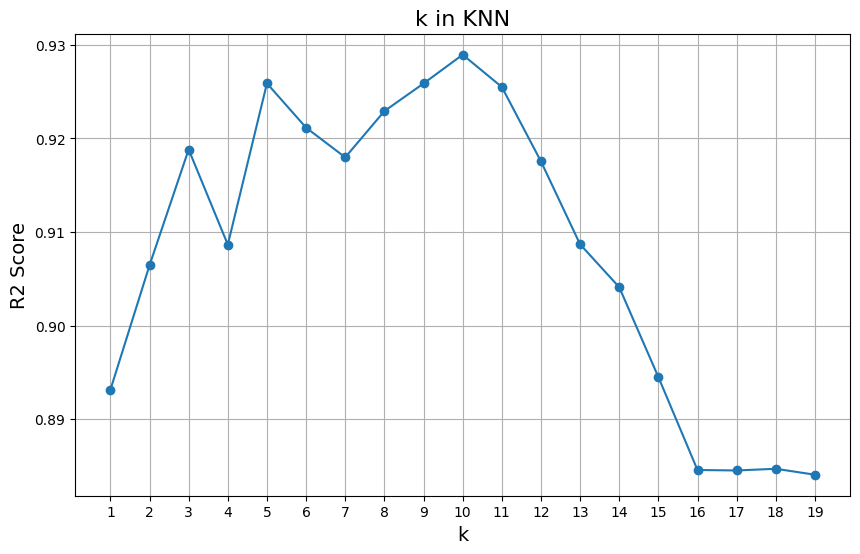

In [ ]:
from sklearn.metrics import r2_score

# 定义范围
k_values = range(1, 20)
r2_scores = []

# 循环计算不同 k 值的 R2 分数
for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    r2_scores.append(r2_score(y_test, y_pred))

# 绘制折线图
plt.figure(figsize=(10, 6))
plt.plot(k_values, r2_scores, marker='o')
plt.title("k in KNN", fontsize=16)
plt.xlabel("k", fontsize=14)
plt.ylabel("R2 Score", fontsize=14)
plt.grid(True)
plt.xticks(k_values)  # 显示每个 K 值
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

knn = KNeighborsRegressor()
param_grid = {'n_neighbors': range(1, 20)}
knn_grid = GridSearchCV(knn, param_grid, cv=5, scoring='r2')
knn_grid.fit(X_train, y_train)
print(f"Best k of KNN: {knn_grid.best_params_}")
knn_best = knn_grid.best_estimator_


Best k of KNN: {'n_neighbors': 2}


In [ ]:

y_pred_knn = knn_best.predict(X_test)

print("KNN：")
print(f"R2 Score: {r2_score(y_test, y_pred_knn)}")
print(f"MSE: {mean_squared_error(y_test, y_pred_knn)}")


KNN：
R2 Score: 0.9064418600663393
MSE: 16046345.178787878


Ramdom Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor


rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30]
}


rf_grid = GridSearchCV(rf, param_grid, cv=5, scoring='r2')
rf_grid.fit(X_train, y_train)


print(f"best parameters: {rf_grid.best_params_}")
rf_best = rf_grid.best_estimator_


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

best parameters: {'max_depth': 10, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [ ]:

y_pred_rf = rf_best.predict(X_test)


print("Ramdom Forest：")
print(f"R2 Score: {r2_score(y_test, y_pred_rf)}")
print(f"MSE: {mean_squared_error(y_test, y_pred_rf)}")


Ramdom Forest：
R2 Score: 0.9269118275190993
MSE: 12535499.796670966


In [ ]:
# Optimiazing sgd
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Standardize features and target
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled_16 = scaler_y.fit_transform(y_train['FP16 GFLOPS'].values.reshape(-1, 1))
y_test_scaled_16 = scaler_y.transform(y_test['FP16 GFLOPS'].values.reshape(-1, 1))

y_train_scaled_32 = scaler_y.fit_transform(y_train['FP32 GFLOPS'].values.reshape(-1, 1))
y_test_scaled_32 = scaler_y.transform(y_test['FP32 GFLOPS'].values.reshape(-1, 1))

y_train_scaled_64 = scaler_y.fit_transform(y_train['FP64 GFLOPS'].values.reshape(-1, 1))
y_test_scaled_64 = scaler_y.transform(y_test['FP64 GFLOPS'].values.reshape(-1, 1))

# Define SGD Regression function
def fit_sgd(X_train, y_train, X_test, y_test, target_name):
    model = SGDRegressor(random_state=42, max_iter=1000, tol=1e-3, alpha=0.0001, eta0=0.01, learning_rate='adaptive')
    model.fit(X_train, y_train.ravel())
    predictions = model.predict(X_test)

    # Inverse transform predictions for evaluation
    predictions_inverse = scaler_y.inverse_transform(predictions.reshape(-1, 1))
    y_test_inverse = scaler_y.inverse_transform(y_test)

    # Calculate metrics
    rmse = mean_squared_error(y_test_inverse, predictions_inverse, squared=False)
    r2 = r2_score(y_test_inverse, predictions_inverse)

    print(f"SGD Regression Results for {target_name}:")
    print(f"RMSE: {rmse}")
    print(f"R2 Score: {r2}\n")

# Example usage for FP16 GFLOPS
fit_sgd(X_train_scaled, y_train_scaled_16, X_test_scaled, y_test_scaled_16, 'FP16 GFLOPS')
fit_sgd(X_train_scaled, y_train_scaled_32, X_test_scaled, y_test_scaled_32, 'FP32 GFLOPS')
fit_sgd(X_train_scaled, y_train_scaled_64, X_test_scaled, y_test_scaled_64, 'FP64 GFLOPS')


SGD Regression Results for FP16 GFLOPS:
RMSE: 4676.244893123086
R2 Score: 0.617294115410287

SGD Regression Results for FP32 GFLOPS:
RMSE: 3480.8938537963204
R2 Score: 0.6439999561362406

SGD Regression Results for FP64 GFLOPS:
RMSE: 4153.3136138202735
R2 Score: 0.49330206101747665



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


XGBOOST


In [ ]:
from xgboost import XGBRegressor


xgb = XGBRegressor(random_state=42, objective='reg:squarederror')
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}


xgb_grid = GridSearchCV(xgb, param_grid, cv=5, scoring='r2')
xgb_grid.fit(X_train, y_train)


print(f"Best Para: {xgb_grid.best_params_}")
xgb_best = xgb_grid.best_estimator_


Best Para: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}


In [ ]:

y_pred_xgb = xgb_best.predict(X_test)


print("XGBoost：")
print(f"R2 Score: {r2_score(y_test, y_pred_xgb)}")
print(f"MSE: {mean_squared_error(y_test, y_pred_xgb)}")


XGBoost：
R2 Score: 0.9341800808906555
MSE: 11288906.156623593


Visualization outcome of different models

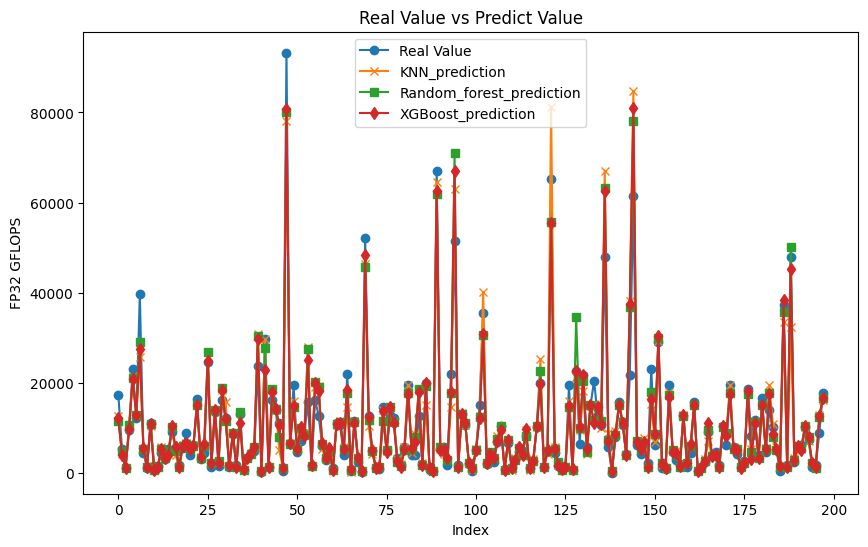

In [ ]:

plt.figure(figsize=(10, 6))

plt.plot(y_test.values, label='Real Value', marker='o')
plt.plot(y_pred_knn, label='KNN_prediction', marker='x')
plt.plot(y_pred_rf, label='Random_forest_prediction', marker='s')
plt.plot(y_pred_xgb, label='XGBoost_prediction', marker='d')

plt.legend()
plt.title('Real Value vs Predict Value')
plt.xlabel('Index')
plt.ylabel('FP32 GFLOPS')
plt.show()


# Automl

In [ ]:
from flaml import AutoML
X = df[['Die Size (mm^2)', 'Transistors (million)', 'TDP (W)']]
y = df['FP32 GFLOPS']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
def auto_ml(max_iter=300):
  automl = AutoML()
  automl_settings = {
    "time_budget": -1,  # in seconds (-1 = unlimited)
    "max_iter": max_iter,
    "metric": "r2",
    "task": "regression",
    "log_file_name": "flaml.log",
    "seed": seed
}
  automl.fit(X_train=X_train, y_train=y_train, **automl_settings)
  y_pred = automl.predict(X_test)
  return automl, y_pred

automl, y_pred = auto_ml(300)



[flaml.automl.logger: 12-08 13:52:09] {1728} INFO - task = regression
[flaml.automl.logger: 12-08 13:52:09] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 12-08 13:52:09] {1838} INFO - Minimizing error metric: 1-r2
[flaml.automl.logger: 12-08 13:52:09] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd']
[flaml.automl.logger: 12-08 13:52:09] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 12-08 13:52:10] {2393} INFO - Estimated sufficient time budget=10000s. Estimated necessary time budget=10s.
[flaml.automl.logger: 12-08 13:52:10] {2442} INFO -  at 1.3s,	estimator lgbm's best error=0.5277,	best estimator lgbm's best error=0.5277
[flaml.automl.logger: 12-08 13:52:10] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 12-08 13:52:10] {2442} INFO -  at 1.5s,	estimator lgbm's best error=0.5277,	best estimator lgbm's best error=0.5277
[flaml.automl.logger: 12-08 13:52:10] {2258}

INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


[flaml.automl.logger: 12-08 13:52:15] {2442} INFO -  at 5.8s,	estimator sgd's best error=1.0061,	best estimator xgb_limitdepth's best error=0.0517
[flaml.automl.logger: 12-08 13:52:15] {2258} INFO - iteration 20, current learner lgbm
[flaml.automl.logger: 12-08 13:52:15] {2442} INFO -  at 5.9s,	estimator lgbm's best error=0.0625,	best estimator xgb_limitdepth's best error=0.0517
[flaml.automl.logger: 12-08 13:52:15] {2258} INFO - iteration 21, current learner xgb_limitdepth
[flaml.automl.logger: 12-08 13:52:15] {2442} INFO -  at 6.1s,	estimator xgb_limitdepth's best error=0.0517,	best estimator xgb_limitdepth's best error=0.0517
[flaml.automl.logger: 12-08 13:52:15] {2258} INFO - iteration 22, current learner xgboost
[flaml.automl.logger: 12-08 13:52:15] {2442} INFO -  at 6.2s,	estimator xgboost's best error=0.3779,	best estimator xgb_limitdepth's best error=0.0517
[flaml.automl.logger: 12-08 13:52:15] {2258} INFO - iteration 23, current learner xgb_limitdepth
[flaml.automl.logger: 12-

Best Model: extra_tree
R² Score: 0.9241150631586647
MSE: 13015178.489974272


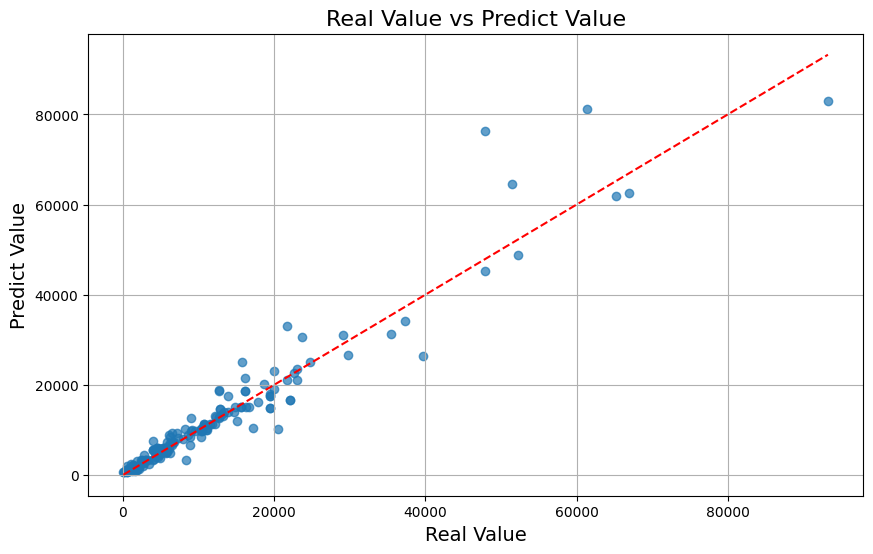

In [ ]:
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("Best Model:", automl.best_estimator)

print(f"R² Score: {r2}")
print(f"MSE: {mse}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Real Value vs Predict Value", fontsize=16)
plt.xlabel("Real Value", fontsize=14)
plt.ylabel("Predict Value", fontsize=14)
plt.grid(True)
plt.show()
